# Generative Adversarial Network (GAN)

**Project Status:** work in progress; next step: add accuracy metrics for the discriminator.

## Objectives
* Explore GAN
* Create deep fake images

## Sources:
* [Deep Convolutional Generative Adversarial Network](https://www.tensorflow.org/tutorials/generative/dcgan)
* [Generative Adversarial Networks](https://developers.google.com/machine-learning/gan)
* [How to Develop a GAN to Generate CIFAR10 Small Color Photographs](https://machinelearningmastery.com/how-to-develop-a-generative-adversarial-network-for-a-cifar-10-small-object-photographs-from-scratch/)
* [How to Configure Image Data Augmentation in Keras](https://machinelearningmastery.com/how-to-configure-image-data-augmentation-when-training-deep-learning-neural-networks/)
* [Kaggle dataset: 275 Bird Species](https://www.kaggle.com/gpiosenka/100-bird-species)

## Table of contents
0. [Introduction](#Introduction)
1. [Import modules](#Import-modules)
1. [Load and prepare image dataset](#Load-&-prepare-image-dataset)
2. [Create models: generator & discriminator](#Create-models)
3. [Define loss & optimizers](#Discriminator-loss)
4. [Train & save models](#Train-&-save-models)
5. [Reload models & generate fake image](#Reload-models-&-generate-fake-image)

## Introduction

## What is GAN?
GAN = generative model; creates new data instances similar to the training data.

## How?
GAN pairs 2 neural network models together:
* a generator: learns to generate the target output
* a discriminator: a classifier that learns to distinguish the real data from the output created the generator.

"The generator tries to fool the discriminator, and the discriminator tries to keep from being fooled."
The discriminator penalizes the generator when it performs badly: the backpropagation allows to update the weights of the generator.

"Backpropagation adjusts each weight in the right direction by calculating the weight's impact on the output — how the output would change if you changed the weight."

## GAN applications
* [GAN Variations](https://developers.google.com/machine-learning/gan/applications)
* [18 Impressive Applications of Generative Adversarial Networks (GANs)](https://machinelearningmastery.com/impressive-applications-of-generative-adversarial-networks/)
* [Some cool applications of GAN](https://jonathan-hui.medium.com/gan-some-cool-applications-of-gans-4c9ecca35900)




## Import modules

In [1]:
# modules to handle files
from os import makedirs
import pathlib
import PIL
import imageio

# module to prepare data and train model
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

# module to display
from matplotlib import pyplot as plt
from IPython import display

# module to track runtime
import time
from datetime import date

In [3]:
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

IndexError: list index out of range

## Load & prepare image dataset

In [ ]:
# if you run the notebook on colab
# mount drive to access the dataset
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# get project directory
# project_dir = pathlib.Path("/content/drive/MyDrive/BeCode/Projects/dd-gan")
project_dir = pathlib.Path("")


# get dataset directory
train_data_dir = project_dir / "kaggle_birds_224x224/train"
train_data_dir

WindowsPath('kaggle_birds_224x224/train')

In [5]:
# define CONSTANTS
IMG_HEIGHT: int = 100
IMG_WIDTH: int = 100
BATCH_SIZE: int = 18

In [6]:
# create custom preprocessing function
def scale_image(img, mode="[-1,1]") -> np.ndarray:
    """
    Function to scale pixel values of an image:
    * mode = "[-1,1]"
      * from the range of unsigned integers in [0,255]
      * to the normalized range of float in [-1,1]
    
      Reason:
      - Generator model will generate fake images with pixel values in range [-1,1]
      as it will use the tanh activation function.
      - Discriminator model will take as input real and fake images.
    
    => Good practice for the real images and the fake images to be scaled to the same range.

    * mode = "[0,1]"
      * from the normalized range of float in [-1,1]
      * to the range of float in [0,1]

      Reason:
        - for displaying the image
    """
    if mode == "[-1,1]":
      # convert from unsigned int to float
      img: np.ndarray = img.astype(np.float32)
      
      # scale from [0,255] to [-1,1]
      img = (img - 127.5) / 127.5
    
    elif mode == "[0,1]":
      # scale image from [-1,1] to [0,1]
      img = (img + 1)/2

    return img

In [7]:
# create image data augmentation generator
train_datagen: tf.keras.preprocessing.image.ImageDataGenerator
train_datagen = ImageDataGenerator(
    preprocessing_function=scale_image
    # featurewise_center=True, # set inputs mean to 0 over the dataset, feature-wise
    # featurewise_std_normalization=True # divide inputs by std of the dataset, feature-wise
    # rescale=1./255,
    # shear_range=0.2,
    # zoom_range=0.2,
    # horizontal_flip=True
                                  )
# choose bird species to train your models on, comment this line to train on the whole dataset
# classes: list = ["BANANAQUIT", "BIRD OF PARADISE", "AMERICAN REDSTART", "AMERICAN COOT", "ANTBIRD"]

# create iterator
train_iterator: tf.keras.preprocessing.image.DirectoryIterator
train_iterator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH), # resize images to (height, width)
    batch_size= BATCH_SIZE,
    shuffle=True,
    # color_mode="grayscale", # to generate b&w images (1 channel)
    # classes=classes, # comment this line to train on the whole dataset
    class_mode=None,  # this means our generator will only yield batches of data, no labels
)

Found 39364 images belonging to 275 classes.


In [8]:
# print total number of images
print("total number of images: ", train_iterator.samples)

# print number of batches with a batch size of 9 images
print("Number of batches: ", len(train_iterator))

total number of images:  39364
Number of batches:  2187


### Plot 1 batch of images

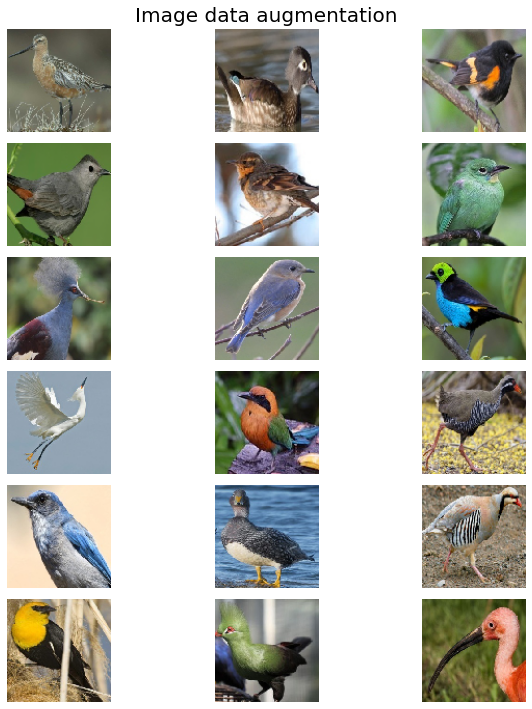

In [9]:
# set subplots grid
LEN_ROWS: int = 3
LEN_COLS: int = 3
fig, ax = plt.subplots(BATCH_SIZE//LEN_ROWS,LEN_COLS, figsize=(10,10))

# generate 1 batch of images
batch: np.ndarray = train_iterator.next()

# plot images
for i in range(BATCH_SIZE):
    
    # define subplot
    ax_i=ax[i//LEN_ROWS,i - LEN_COLS*(i//LEN_COLS)]
    
    # scale image from [-1,1] to [0,1]
    # img = ((batch[i] + 127.5) * 127.5).astype('uint8')
    img = scale_image(batch[i], mode="[0,1]")

    # turn off axis
    ax_i.axis("off")
    
    # plot raw pixel data
    ax_i.imshow(img)
   
# show the figure
fig.suptitle('Image data augmentation', fontsize=20)
fig.tight_layout()
fig.subplots_adjust(top=0.95)
plt.show()

## Create models

### Create generator

**Convolutional Neural networks:**
We start from an image, then apply filters to extract different features, to end with a vector. 
--> Thus, inside the model, there are many parallel filters resulting in multiple parallel activation maps (= the feature maps).
Each feature map extracts different features from the input image, i.e. has different interpretations of the input image.


**Deconvolutional Neural Network (= a reverse CNN):**
Such as the generator here.
We start from a vector, then build low-resolution versions of an image, build higher resolution versions to finally combine them into a final image.
--> Thus, inside the model, there are many many parallel versions of the image, with different learned features, that can then be combined into the final image.

=> 1st hidden layer (Dense layer) needs enough nodes for multiple versions of the image: e.g. 256 different features

Batch normalization
Batch normalization is a form regularization (dropout is another form). that rescales the outputs of a layer to make sure that they have mean 0 and standard deviation 1.

rescale the output of a layer so that it always has 0 mean and standard deviation of 1 in every batch of training
=> solves the problem where different batches of input might produce wildly different distributions of outputs in any given layer in the network -> makes the training go faster

!! sometimes disharmony between dropout and batch normalization (i.e don't work well together):

dropout slows down the training, making it more incremental and careful
batch normalization makes the training go faster => their effects may in fact counter each other and networks sometimes perform worse

In [10]:
def make_generator_model(random_noise_dim, output_height, output_width):
    """
    Function to create a generator model
    with Keras Sequential API.

    params:
    * random_noise_dim = dimensions of random noise vector
    * output_height = height (in pixels) of the image output by the generator
    * output_width = width (in pixels) of the image output by the generator
    """
    # get fraction of the output height and width for the low-resolution images
    height = int(output_height/4)
    width = int(output_width/4)

    # instantiate sequential model
    model = tf.keras.Sequential()
    
    # add dense layer
    # Dense layer needs enough nodes for multiple versions of the image: e.g. 256 different features
    model.add(tf.keras.layers.Dense(height*width*256, use_bias=False, input_shape=(random_noise_dim,)))

    # add batch normalization layer
    # to rescale the output of the previous layer so that it always has 0 mean and standard deviation of 1 in every batch of training
    model.add(tf.keras.layers.BatchNormalization())
    
    # add LeakyReLU activation function
    # with a default slope of 0.2 reported as best practice when training GAN models
    model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
    
    # add Reshape layer
    # to reshape the activations from the nodes to sth image-like
    # to pass into a convolutional layer: e.g. 256 different 25x25 pixels feature maps
    model.add(tf.keras.layers.Reshape((height,width,256)))

    # assert the output shape of the layer
    assert model.output_shape == (None,height,width,256) # None is the batch size (here we don't assess the batch size)
    
    # add deconvolutional layer:
    # Conv2DTranspose (combines 2 operations: UpSampling2D layer and a normal Conv2D layer)
    # UpSampling2D is like a reverse pooling layer
    model.add(tf.keras.layers.Conv2DTranspose(128, (4,4), strides=(1,1), padding="same", use_bias=False))
    assert model.output_shape == (None,height,width,128)
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    
    # upsampling the low-resolution image into a higher resolution version of the image
    # with deconvolutional layer
    # stride of (2x2): will quadruple the area of the feature maps (height * 2, width * 2)
    # good practice to use a kernel size that is a factor of the stride 
    # to avoid a checkerboard pattern that can sometimes be observed when upsampling
    # e.g: from 25x25 pixels to 50x50 pixels
    model.add(tf.keras.layers.Conv2DTranspose(128, (4,4), strides=(2,2), padding="same", use_bias=False))
    assert model.output_shape == (None,height*2,width*2,128)
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    
    # upsampling the low-resolution image into a higher resolution version of the image
    # e.g: from 50x50 pixels to 100x100 pixels
    model.add(tf.keras.layers.Conv2DTranspose(128, (4,4), strides=(2,2), padding="same", use_bias=False))
    assert model.output_shape == (None,output_height,output_width,128)
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    
    # define output layer: 
    # 3 filters (= kernel of size 3x3) for the 3 required channels
    # 'same' padding to preserve its dimensions: e.g. 100x100x3 pixels
    # tanh activation to ensure output values are in [-1,1], a current best practice
    model.add(tf.keras.layers.Conv2D(3, (3,3), activation="tanh", padding="same"))
    assert model.output_shape == (None, output_height, output_width, 3)
    
    return model
    

Alternatively, you can also replace the previous output layer by
```python
model.add(tf.keras.layers.Conv2DTranspose(3, (4,4), strides=(1,1), padding="same", use_bias=False, activation="tanh"))
assert model.output_shape == (None, output_height, output_width, 3)
```

### create an image with the initial generator (not yet trained)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 160000)            16000000  
_________________________________________________________________
batch_normalization (BatchNo (None, 160000)            640000    
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 160000)            0         
_________________________________________________________________
reshape (Reshape)            (None, 25, 25, 256)       0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 25, 25, 128)       524288    
_________________________________________________________________
batch_normalization_1 (Batch (None, 25, 25, 128)       512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 25, 25, 128)       0

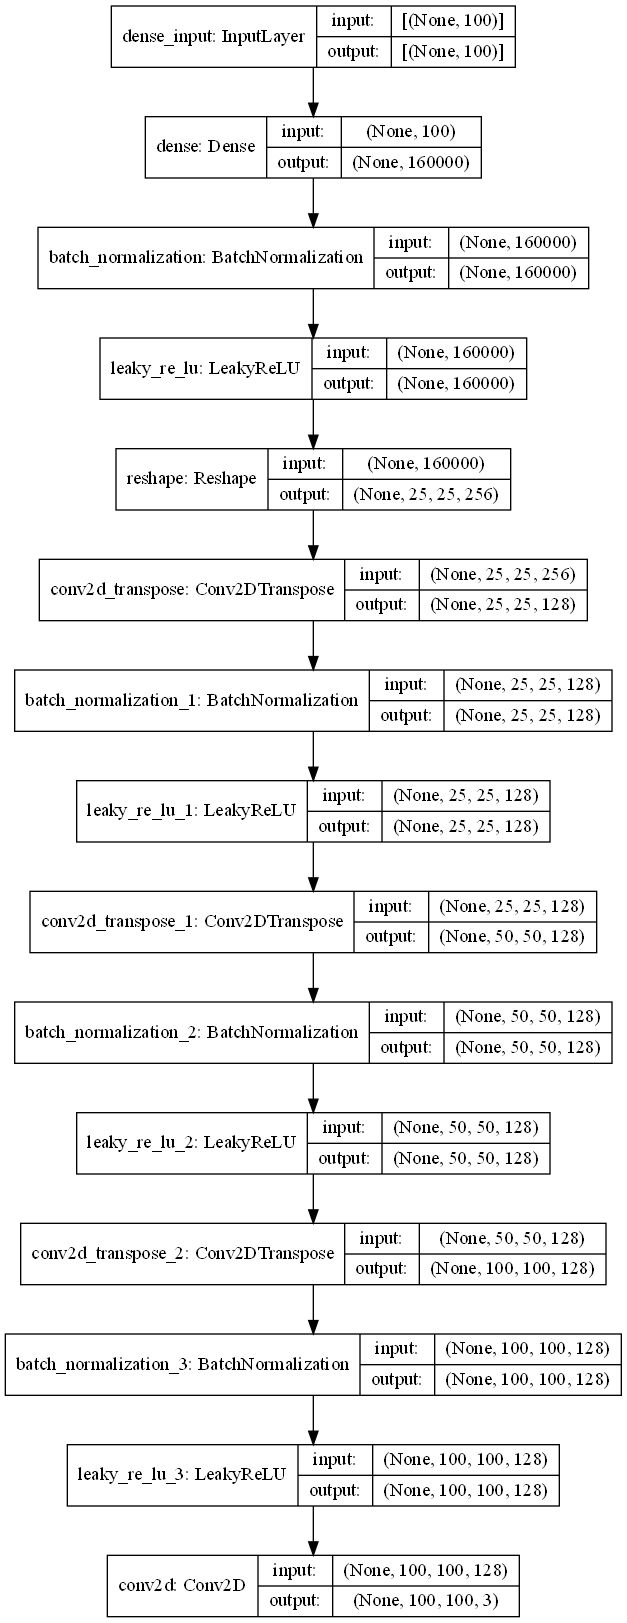

In [11]:
# define dimensions of latent space (= random noise)
# 100 dimensions is widely used, feel free to try with other numbers (e.g. 10, 50, 200 or 500)
RANDOM_NOISE_DIM = 100

# instantiate generator model
generator = make_generator_model(RANDOM_NOISE_DIM, IMG_HEIGHT, IMG_WIDTH)

# summarize model
generator.summary()

# plot model, save the plot
# you have to install pydot and graphviz libraries
generator_plot_filepath = project_dir / "generator_plot.png"
tf.keras.utils.plot_model(generator, to_file=generator_plot_filepath, show_shapes=True, show_layer_names=True)

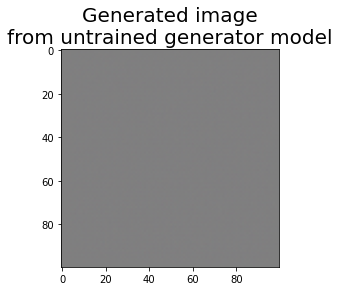

In [12]:
# input noise into model to generate an image
random_noise = tf.random.normal([1, 100])
generated_images = generator(random_noise, training=False)

# scale image from [-1,1] to [0,1]
generated_image = scale_image(generated_images[0], mode="[0,1]")

# show generated image
plt.imshow(generated_image)

# show the figure
plt.title('Generated image\nfrom untrained generator model', fontsize=20)
plt.show()

Model is not yet trained => the generated images are completely random pixel values in [-1, 1], rescaled to [0, 1]. The images should look sth like plain gray.

### Create discriminator

In [13]:
def make_discriminator_model(input_shape=(100,100,3)):
    """
    Function to create a discriminator model
    with Keras Sequential API.

    params:
    * input_shape = image size (height pixels, width pixels, number of channels)
    """
    # instantiate sequential model
    model = tf.keras.Sequential()

    # normal convolutional layer
    model.add(tf.keras.layers.Conv2D(64, (5,5), padding="same", input_shape=input_shape))
    model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
    # model.add(tf.keras.layers.Dropout(0.3))
    
    # downsample
    model.add(tf.keras.layers.Conv2D(128, (5,5), strides=(2,2), padding="same"))
    model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
    # model.add(tf.keras.layers.Dropout(0.3))
    
    # downsample
    model.add(tf.keras.layers.Conv2D(128, (5,5), strides=(2,2), padding="same"))
    model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
    
    # downsample
    model.add(tf.keras.layers.Conv2D(256, (5,5), strides=(2,2), padding="same"))
    model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
    
    # classifier:
    # add Flatten layer to translate between the image processing and classification part of your network
    # i.e flatten used as a connector between convolution and densely connected layers
    # it takes the output of the convolution layer (the "feature map") and flatten it into a 1D array
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dropout(0.4))
    model.add(tf.keras.layers.Dense(1, activation="sigmoid"))
    
    # compile model
    # opt = tf.keras.optimizers.Adam(lr=0.0002, beta_1=0.5)
    # model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])
    
    return model

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 100, 100, 64)      4864      
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 100, 100, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 50, 50, 128)       204928    
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 50, 50, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 25, 25, 128)       409728    
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 25, 25, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 13, 13, 256)      

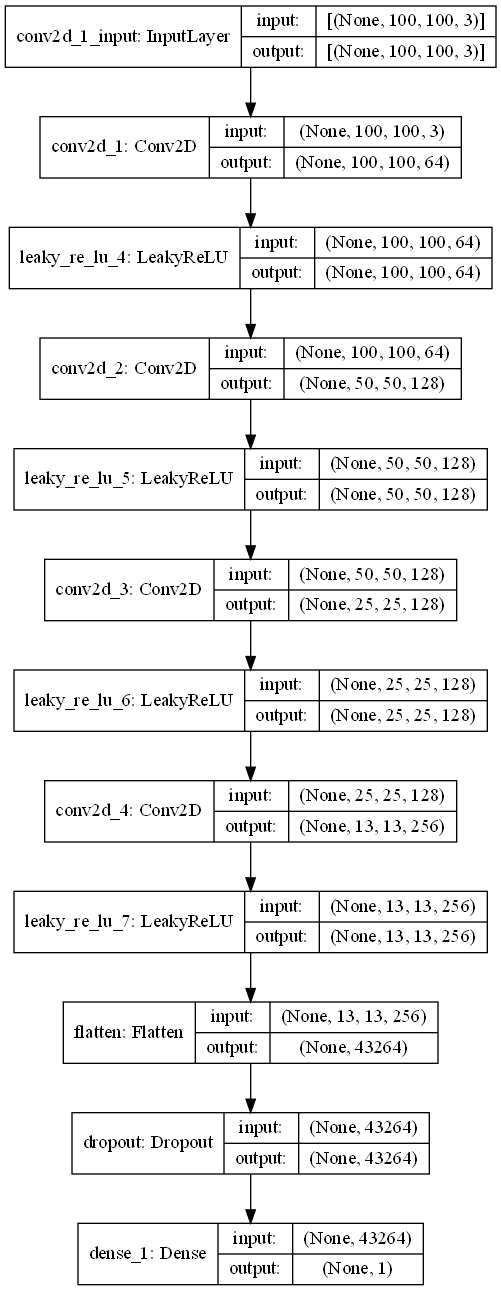

In [14]:
# instantiate model
discriminator = make_discriminator_model()

# summarize model
discriminator.summary()

# plot model, save the plot
# you have to install pydot and graphviz libraries
discriminator_plot_filepath = project_dir / "discriminator_plot.png"
tf.keras.utils.plot_model(discriminator, to_file=discriminator_plot_filepath, show_shapes=True, show_layer_names=True)

For information: here is how to calculate 
1. the number of parameters in a layer
2. the size of a layer output

(Feel free to turn these operations into functions)

In [15]:
# the number of parameters in 1st layer is
## 64 kernels of 3x3 pixels in the 3 channels + 64 bias terms
print("number of parameters in 1st layer: ", 64*5*5*3 + 64)

# the number of parameters in last layer (dense layer) is
## 43264 (the big 1D array) * 1 unit + 1 bias terms
print("number of parameters in last layer: ", 43264*1 + 1)

number of parameters in 1st layer:  4864
number of parameters in last layer:  43265


In [16]:
# calculate output size of a convolutional layer
# e.g. input shape (100,100,64) into Conv2D(128, (5,5), strides=(2,2), padding="same")

#=> output shape should be (50,50,128) # with 128 as the number of filters

input_shape: tuple = (100,100,64)
output_shape: list = []

# convolution layer parameters:
nb_filters = 128 # number of filters (= nodes)
kernel = 5 # Kernel size: 5
padding = "same" # padding: padding of zeros around the input image
# if "same", add `pad` padding such that output image has the same dimensions as input image
if padding == "same":
    pad = (kernel - 1)/2 # padding size
# if "valid" (by default), no padding
elif padding == "valid":
    pad = 0
stride = 2 # strides of 2 pixels

# iterate over the 1st 2 dimensions (the last dimension is added after the loop)
# here: 1st dimension = 100 pixels
for input_dimension in input_shape[:-1]:

  # formula to calculate output size of a convolutional layer
  output_size = int(((input_dimension - kernel + 2*pad)/stride) + 1)

  # append output size to output_shape
  output_shape.append(output_size)

# append number of filters to output_shape
output_shape.append(nb_filters)

output_shape = tuple(output_shape)
output_shape

(50, 50, 128)

### Classify an image with the initial discriminator (not yet trained):
Binary classification:
discriminator model outputs probability of image being real (or fake)

In [17]:
# classify image
decision = discriminator(generated_images)
print(decision)

tf.Tensor([[0.49992114]], shape=(1, 1), dtype=float32)


## Define loss and optimizers

In [18]:
# define helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

### Generator loss
Quantifies how well generator fools discriminator. A good generator should make the discriminator classify fake images as real (1) => loss should:
- compare discriminator's predictions on fake images to an array of 1s.

In [19]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

### Discriminator loss
Quantifies how well discriminator classify real and fake images => loss should:
- compare discriminator's predictions on real images to an array of 1s (as the discriminator outputs need to go close to 1)
- loss should compare discriminator's predictions on fake images to an array of 0s (as the discriminator outputs need to go close to 0)

In [20]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

### Optimizers
Different discriminator and generator optimizers as we train the 2 networks separately.

We use the efficient Adam version of stochastic gradient descent, with the learning rate of 0.0002 and momentum of 0.5, recommended when training deep convolutional GANs.

In [21]:
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5)

## Train & save checkpoints

### Save checkpoints

In [22]:
# set checkpoint directory where to save the checkpoints
checkpoint_dir = project_dir / "training_checkpoints"

# set checkpoint prefix
checkpoint_prefix = checkpoint_dir / "ckpt"

# checkpoint_dir: str = "./training_checkpoints"
# checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")

# instantiate Checkpoint object with models and optimizers
checkpoint = tf.train.Checkpoint(
    generator_optimizer=generator_optimizer,
    discriminator_optimizer=discriminator_optimizer,
    generator=generator,
    discriminator=discriminator
                                )

### Save fake images


In [23]:
# create directory where to save the fake images during training
fake_images_dir = project_dir / "training_images"
makedirs(fake_images_dir, exist_ok=True)

In [24]:
def generate_and_save_images(generator_model, test_random_noise, epoch):
  """
  Function to generate fake images, display in a grid of 4x4 images
  and save the figure
  """
  # generate fake images
  # training = False to make all layers run in inference mode
  generated_images = generator_model(test_random_noise, training=False)

  # get number of generated_images
  nb_generated_images = generated_images.shape[0]
  
  # set figure size
  fig = plt.figure(figsize=(4,4))

  # iterate over all generated images
  for i in range(nb_generated_images):
      # define subplot
      plt.subplot(nb_generated_images//4,4,i+1)
      # plt.imshow((predictions[i, :, :, :] + 1)/2)
      plt.imshow(scale_image(generated_images[i], mode="[0,1]"))
      plt.axis("off")

  # set title
  # plt.title(f"{epoch:04d}")

  # save image
  image_filepath = fake_images_dir / f"image_at_epoch_{epoch:04d}.png" # e.g. image_at_epoch_0001.png
  plt.savefig(image_filepath)

  # display plot
  plt.show()

### Training loop
1. input random noise into generator
2. generator produces an image
3. discriminator classifies real images (from training set) and fake images (from generator)
4. calcul loss for each model
5. get gradients 
6. use gradients to update generator and discriminator with optimizers

#### Training functions

In [25]:
@tf.function # decorator to compile the function
def train_step(real_images):
  """
  Function to train generator and discriminator  
  on 1 batch of random noises and real images
  """
  # create random noise
  random_noise = tf.random.normal([BATCH_SIZE, RANDOM_NOISE_DIM])
  
  # track gradients
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      
      # 1. 2. generate image from noise as input
      generated_images = generator(random_noise, training=True)
      
      # 3. classify real images & fake images
      real_output = discriminator(real_images, training=True)
      fake_output = discriminator(generated_images, training=True)
      
      # 4. compute generator loss & discriminator loss
      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)
      
  # 5. get gradients of generator & discriminator
  gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
  gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

  # 6. use gradients to update generator & discriminator weights
  generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [28]:
def train(train_iterator, test_random_noise, epochs):
  """
  Function to train generator and discriminator  
  on multiple epochs
  """
  # iterate over the epochs
  for epoch in range(1, epochs + 1):
      start_time = time.time()
      
      # iterate over the batches
      for _ in range(len(train_iterator)):
          image_batch = train_iterator.next()
          train_step(image_batch)
        
      # clear previous output when new fake images are displayed
      display.clear_output(wait=True) # true to let the output displayed until next one

      # produce and save images for animated GIF
      generate_and_save_images(generator, test_random_noise, epoch)
      
      # save model every 15 epochs
      if epoch % 15 == 0:
        checkpoint.save(file_prefix = checkpoint_prefix)
      # checkpoint.save(file_prefix = checkpoint_prefix)
      
      end_time = time.time()
      runtime_s = end_time - start_time
      print(f"time for epoch {epoch}: {runtime_s} sec")
    
  # clear previous output when new fake images are displayed
  display.clear_output(wait=True)

  # generate image after training (i.e after final epoch)
  generate_and_save_images(generator, test_random_noise, epochs)

#### Train
Call the train() function to train the generator and discriminator concurrently.

Important that both models train at a similar rate so that they don't overpower each other.

In [29]:
# random noise input to visualize progress in animated GIF of 16 images
TEST_RANDOM_NOISE_DIM = 100
NB_EXAMPLES_TO_GENERATE = 16
TEST_RANDOM_NOISE = tf.random.normal([NB_EXAMPLES_TO_GENERATE, TEST_RANDOM_NOISE_DIM])

# set number of epochs
EPOCHS = 500

# train generator and discriminator
train(train_iterator, TEST_RANDOM_NOISE, EPOCHS)

C:\Users\Haro\anaconda3\envs\tf_gpu\lib\site-packages\keras\backend.py:4993: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  warnings.warn(


KeyboardInterrupt: 

## Reload models & generate fake image
You can reload the latest saved models,
generate fake images
or continue training the models

In [26]:
# Restore latest checkpoint
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

# you can also restore any specific checkpoint
# checkpoint.restore("/content/training_checkpoints/ckpt-10")

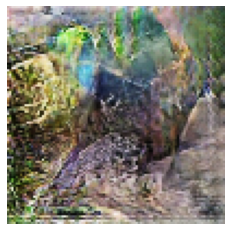

In [52]:
# input noise into model to generate an image
noise = tf.random.normal([1, 100])
generated_images = generator(noise, training=False)

# scale image from [-1,1] to [0,1]
generated_image = (generated_images[0] + 1) / 2

# display image
plt.imshow(generated_image)

# turn off axis
plt.axis("off")
plt.show()

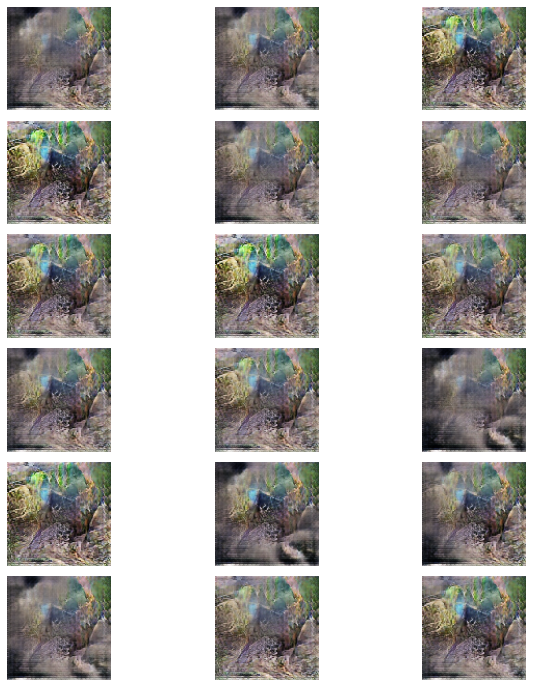

In [54]:
# set subplots grid
LEN_ROWS: int = 3
LEN_COLS: int = 3
fig, ax = plt.subplots(BATCH_SIZE//LEN_ROWS,LEN_COLS, figsize=(10,10))

# input noise into model to generate an image
noise = tf.random.normal([BATCH_SIZE, 100])
generated_images = generator(noise, training=False)

# plot images
for i in range(BATCH_SIZE):
    
    # define subplot
    ax_i=ax[i//LEN_ROWS,i - LEN_COLS*(i//LEN_COLS)]
    
    # scale image from [-1,1] to [0,1]
    # img = ((batch[i] + 127.5) * 127.5).astype('uint8')
    img = scale_image(generated_images[i], mode="[0,1]")

    # turn off axis
    ax_i.axis("off")
    
    # plot raw pixel data
    ax_i.imshow(img)
   
# show the figure
# fig.suptitle('Generated images', fontsize=20)
fig.tight_layout()
fig.subplots_adjust(top=0.95)
plt.show()

In [776]:
# copy checkpoint to another directory
# import shutil
# target = r'/content/drive/MyDrive/BeCode/Projects'
# checkpoint_files: list = [r'/content/training_checkpoints/ckpt-50.data-00000-of-00001',
#                 r'/content/training_checkpoints/ckpt-50.index',
#                 r'/content/training_checkpoints/checkpoint']

# for original in checkpoint_files:
#  shutil.copy(original,target)

In [777]:
# delete checkpoints folder
# import shutil
# shutil.rmtree('/content/training_checkpoints')

## Create GIF

In [89]:
# display single image using epoch number
def display_image(epoch):
  return PIL.Image.open(fake_images_dir / f"image_at_epoch_{epoch:04d}.png")

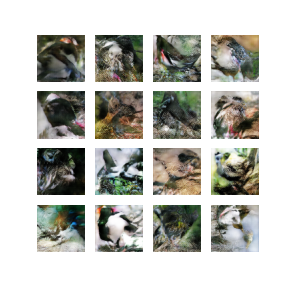

In [90]:
display_image(2)

Use `imageio` module to create animated gif using the images saved during training.

In [732]:
# set gif filename with current date
today = date.today().strftime("%Y%m%d")

gif_file = project_dir / f'dcgan_{today}.gif'

# write gif within context manager
with imageio.get_writer(gif_file, mode='I') as writer:
  
  # get list of saved images and sort them
  filenames = fake_images_dir.glob('image*.png')
  filenames = sorted(filenames)

  # iterate over the images to add frame to gif
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)